In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,StandardScaler

# RandomForest Classifier
## Data Preprocessing :

In [1]:
df_binary=pd.read_csv("/kaggle/input/binary-classified-ciciot-2023-dataset/EqualBinaryData_CICIoT_2023 (1).csv")
df_multi_class=pd.read_csv("/kaggle/input/classwise-balanced-ciciot-2023/ClassWise_Labeled_Balanced_Dataset.csv")
df_multi_class=pd.read_csv("/kaggle/input/top-5-classes/CICIoT_2023_5_big_classes.csv")



#### This data contains infinite values in Rate columns which cannot be handled by imputer so we have to do it manually

In [47]:
#Binary Classification
# df=pd.DataFrame(df_binary.copy())

df=pd.DataFrame(df_multi_class)
df=df.sample(frac=1,random_state=42)
# target_values=['MIRAI','Normal','DDOS','SPOOFING']
target_values=["DDoS","Mirai","Benign"]

df=df[df['Label'].isin(target_values)]
# df=df.drop(['IPv', 'LLC', 'Tot size'],axis=1)
# df=df[['DHCP','SSH','fin_count','ICMP','Variance','fin_flag_number','DNS','rst_flag_number','rst_count','syn_count','Label']]
df['Label'].value_counts()
df.columns

Index(['Unnamed: 0', 'Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label'],
      dtype='object')

In [48]:
# df=df.drop(columns=['Unnamed: 0',"Number","Unnamed: 0.1"])
df=df.drop(columns=['Unnamed: 0',"Number"])

df=df.replace(np.inf,np.nan)
np.isinf(df['Rate']).value_counts()
df.isnull().sum()
df=df.dropna()

In [49]:
df.isnull().sum()
# df=df.drop(columns=['Unnamed: 0.1'])


Header_Length      0
Protocol Type      0
Time_To_Live       0
Rate               0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IGMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Variance           0
Label              0
dtype: int64

In [50]:
# df=df[['Label','Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'ack_flag_number', 'ack_count', 'HTTPS', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance']]
df=df.sample(frac=1,random_state=42).reset_index(drop=True)

In [56]:
from sklearn.preprocessing import LabelEncoder
df=df.groupby("Label").sample(n=1000,random_state=42).reset_index(drop=True)
print(df['Label'].value_counts())
X=df.drop('Label',axis=1)
y=df['Label']
ST=StandardScaler()
LE=LabelEncoder()
X_encoded=ST.fit_transform(X)
y_encoded=LE.fit_transform(y)
# 1. First Split: Separate the Final Test Set (10%)
# This X_test is your "Unseen Data" for the final report
# X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
# x_train_encoded=ST.fit_transform(X_temp)
# x_test_encoded=ST.transform(X_test)

# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_train_encoded, test_size=0.111, random_state=42)

X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

# 2. Second Split: Separate Train (80%) and Validation (10%) from the remaining 90%
# 0.111 of 90% is approx 10% of the total
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42)
# y_train_encoded=LE.fit_transform(y_train)
# y_test_encoded=LE.transform(y_val)

Label
Benign    1000
DDoS      1000
Mirai     1000
Name: count, dtype: int64


In [58]:


# 2. Second Split: Separate Train (80%) and Validation (10%) from the remaining 90%
# 0.111 of 90% is approx 10% of the total


# RF=RandomForestClassifier(max_depth=30,min_samples_split=5,n_estimators=50,random_state=42)
RF=RandomForestClassifier(
    n_estimators=5,           # Increased from 50
    criterion='entropy',        # Changed from 'gini'
    max_depth=5,             # Allow full growth (or try 40+)
    min_samples_split=2,        # Allow finer splits
    # min_samples_leaf=5,         # Capture specific patterns
    # class_weight='balanced_subsample', # Helps with "hard" classes even if count is equal
    random_state=42,
    n_jobs=-1                   # Speed up training
)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_val)
print("Accuracy:",accuracy_score(y_val,y_pred))
y_pred_back=LE.inverse_transform(y_pred)
y_val_back=LE.inverse_transform(y_val)

print("Classification Report:\n",classification_report(y_val_back,y_pred_back))

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      0.99      0.99        79
        DDoS       0.99      0.98      0.99       112
       Mirai       0.98      1.00      0.99       109

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



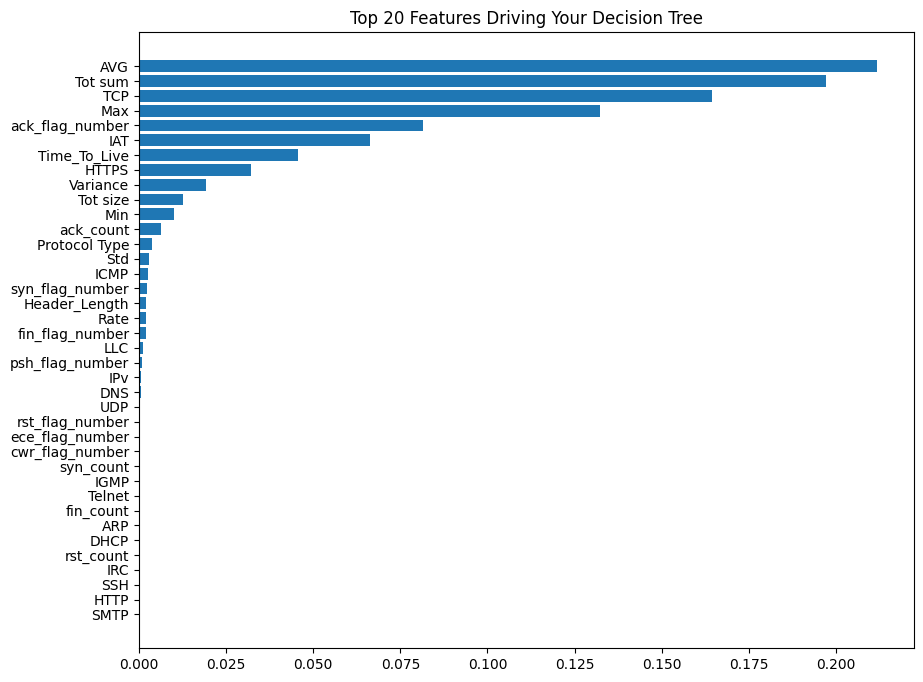

In [59]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load your trained model
# clf = joblib.load("decision_tree_model.joblib")

# Get feature importances
importances = RF.feature_importances_
feature_names = X_train.columns # Make sure X_train is a DataFrame, not numpy array

# Sort and Plot
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_imp_df['Feature'][:42], feature_imp_df['Importance'][:42])
plt.gca().invert_yaxis()
plt.title("Top 20 Features Driving Your Decision Tree")
plt.show()

In [60]:
train_preds=RF.predict(X_train)
test_preds=RF.predict(X_test)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Difference:        {train_acc - test_acc:.4f}")

if train_acc > 0.99 and (train_acc - test_acc) > 0.05:
    print("\nDIAGNOSIS: High probability of OVERFITTING.")
elif train_acc < 0.80:
    print("\nDIAGNOSIS: Likely UNDERFITTING (Model is too simple).")
else:
    print("\nDIAGNOSIS: Good Fit (Generalized well).")

Training Accuracy: 0.9988
Testing Accuracy:  0.9833
Difference:        0.0154

DIAGNOSIS: Good Fit (Generalized well).


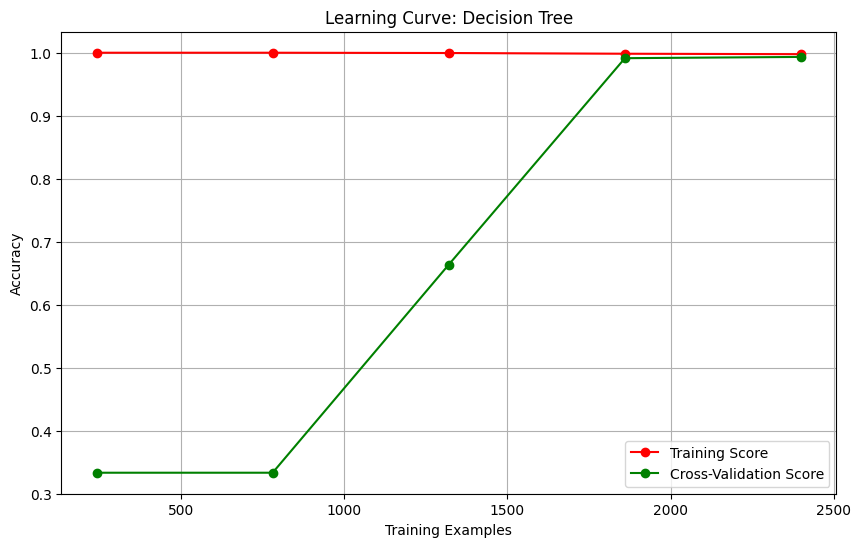

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5) # Check at 10%, 30%, ... 100% of data
    )
    
    # Calculate means
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")
    
    plt.title("Learning Curve: Decision Tree")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


plot_learning_curve(RF, X, y)

In [ ]:
# import time
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],      # Fewer trees = faster/lighter
#     'max_depth': [10, 20, None],         # Limit depth to prevent overfitting/bloat
#     'min_samples_split': [2, 5, 10],     # Higher numbers = simpler trees
#     'min_samples_leaf': [1, 2, 4],       # Higher numbers = simpler trees
#     'bootstrap': [True]                  # Standard for Random Forest
# }

# # --- 2. Initialize the Model ---
# rf = RandomForestClassifier(
#     random_state=42, 
#     class_weight='balanced',  # Critical for multi-class balance
#     n_jobs=-1                 # Use all cores for the base estimator
# )

# # --- 3. Setup Grid Search ---
# # cv=3 is usually enough for large datasets (saves time vs cv=5)
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,                         # 3-Fold Cross Validation
#     n_jobs=-1,                    # Use all CPU cores for the Search
#     verbose=2,                    # Print progress updates
#     scoring='f1_weighted'         # Optimize for F1 Score (better for imbalance than accuracy)
# )

# # --- 4. Run Search ---
# start_time = time.time()
# grid_search.fit(X_train, y_train)
# end_time = time.time()

# print("\n" + "="*40)
# print(f"GRID SEARCH RESULTS")
# print(f"Time Taken: {(end_time - start_time)/60:.2f} minutes")
# print("="*40)

# # Best Parameters
# print(f"Best Parameters found: {grid_search.best_params_}")
# print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

# # --- 5. Evaluate Best Model on Test Set ---
# best_rf = grid_search.best_estimator_

# print("\n--- Final Evaluation on Test Set ---")
# y_pred = best_rf.predict(X_test)

# print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

GridSearch result on binary data:

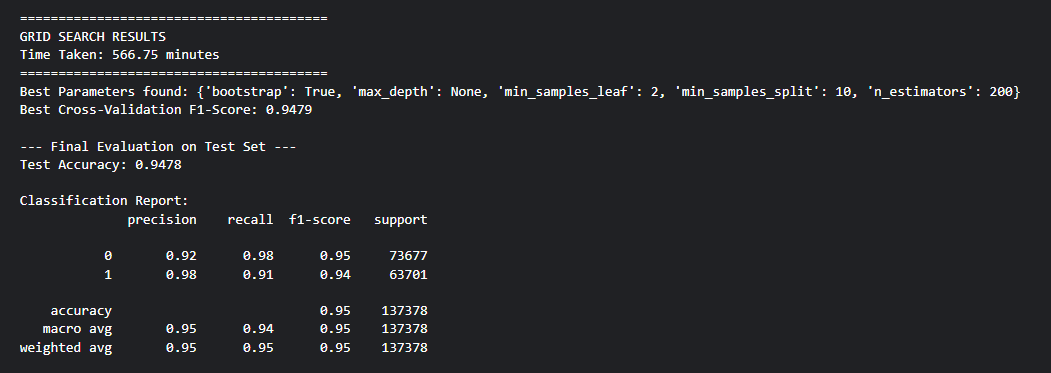

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFE
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # --- Configuration ---
# DATA_PATH = "train_balanced_7classes.csv"
# # ---------------------

# def check_correlation(df):
#     print("\n--- 1. Checking Correlation (Redundancy) ---")
#     # Drop label
#     X = df.drop('Label', axis=1)
    
#     # Calculate correlation matrix
#     corr_matrix = X.corr().abs()
    
#     # Select upper triangle of correlation matrix
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
#     # Find features with correlation greater than 0.95
#     to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
#     print(f"High Correlation Features (Candidates to Drop): {len(to_drop)}")
#     print(to_drop)
    
#     # Optional: Plot Heatmap
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(corr_matrix, cmap='coolwarm')
#     plt.title("Feature Correlation Matrix")
#     plt.show()
#     return to_drop

# def apply_smote(X, y):
#     print("\n--- 2. Applying SMOTE (Balancing Classes) ---")
#     print(f"Original Class Distribution: {Counter(y)}")
    
#     # SMOTE creates synthetic samples
#     smote = SMOTE(random_state=42)
#     X_res, y_res = smote.fit_resample(X, y)
    
#     print(f"Resampled Class Distribution: {Counter(y_res)}")
#     return X_res, y_res

# def run_rfe(X, y):
#     print("\n--- 3. Recursive Feature Elimination (RFE) ---")
#     # Use a small Random Forest for selection
#     rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
    
#     # Select top 15 features
#     rfe = RFE(estimator=rf, n_features_to_select=15, step=1)
#     rfe.fit(X, y)
    
#     selected_features = X.columns[rfe.support_]
#     print(f"Top 15 Features Selected by RFE:")
#     print(list(selected_features))
    
#     return list(selected_features)

# def main():
#     import numpy as np # Import locally if needed
    
#     print("Loading Data...")
#     # df = pd.read_csv(DATA_PATH)
    
#     # Clean up
#     drop_cols = ['Label', 'Number', 'Unnamed: 0']
#     cols_to_drop = [c for c in drop_cols if c in df.columns]
#     X = df.drop(columns=cols_to_drop, axis=1)
#     y = df['Label']
    
#     # Encode y
#     le = LabelEncoder()
#     y_enc = le.fit_transform(y)

#     # 1. Check Correlation
#     high_corr_features = check_correlation(df)
    
#     # 2. Run SMOTE (Optional - helps with weak classes)
#     X_smote, y_smote = apply_smote(X, y_enc)
    
#     # 3. Run RFE to find the "Perfect Lightweight Subset"
#     # We use a sample to speed it up
#     X_sample, _, y_sample, _ = train_test_split(X_smote, y_smote, train_size=0.1, random_state=42, stratify=y_smote)
#     best_features = run_rfe(X_sample, y_sample)
    
#     print("\n--- Recommendation ---")
#     print("1. Drop these High Correlation columns to save RAM:", high_corr_features)
#     print("2. Train your XGBoost/RF using ONLY these RFE features:", best_features)

# if __name__ == "__main__":
#     main()

In [ ]:
pip install --upgrade scikit-learn imbalanced-learn

<h1>Final Results</h1>
<h2>Random Forest Classifier classification report of Multiclass Classification</h2>

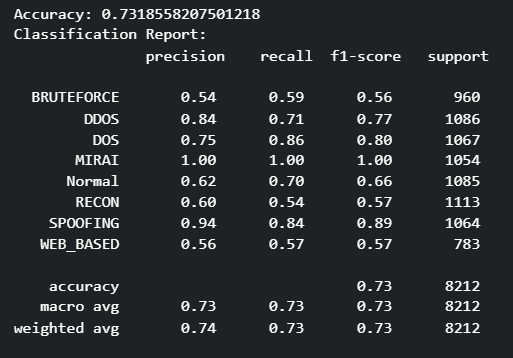

<h2>GridSearch result on binary data </h2>

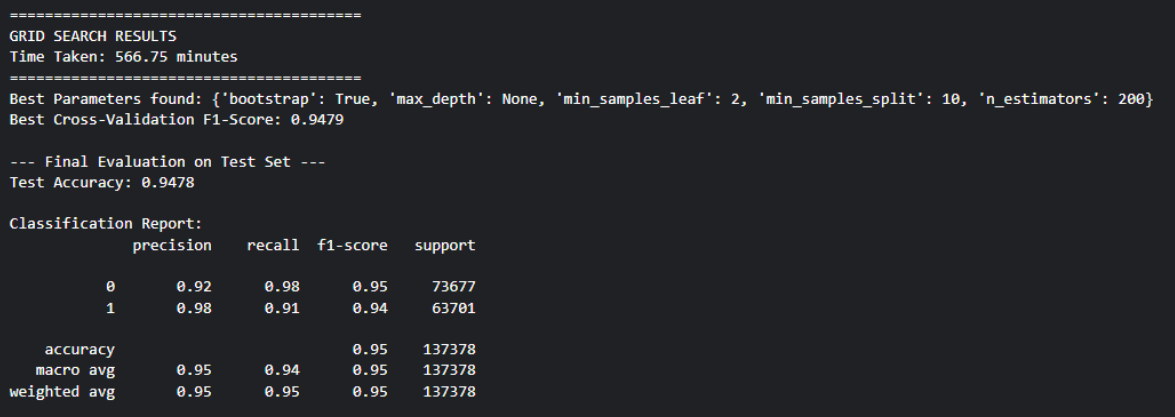

In [9]:
joblib.dump(RF,"/kaggle/working/MultiClass_RF_99%.joblib")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Accuracy: 0.2127
Testing Accuracy:  0.0000
Difference:        0.2127

DIAGNOSIS: Likely UNDERFITTING (Model is too simple).


In [64]:
!pip install micromlgen
from micromlgen import port

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32152 sha256=9a8cbd9b7034a24d987672003b8ae410b64ed5ba912f8e312a22e737a68a2c4d
  Stored in directory: /root/.cache/pip/wheels/aa/3a/19/9fd4635f110202e18f3b4bb631e90287ba06eb406999726cb9
Successfully built micromlgen


In [65]:
print(f"Micro Model Accuracy: {RF.score(X_test, y_test)}")

# 2. Port the model to C code
# This converts the Python object into a C++ header string
c_code = port(RF)

# Save this code to a text file
with open('MultiClass_RF_99%.h', 'w') as f:
    f.write(c_code)

print("Model exported to random_forest_model.h")

Micro Model Accuracy: 0.9833333333333333
Model exported to random_forest_model.h


In [68]:
test=pd.DataFrame(y_test)
X_test.to_csv("x_testing.csv")
test.to_csv("y_testing.csv")